## 01 Graphic - Attributed GMT

In [1]:
import os
os.chdir('/Users/schoens/Documents/PhD/IIASA/04_Code/income_decile')

In [2]:
from pathlib import Path

import pandas as pd 
import numpy as np
import geopandas as gpd 
from shapely import box
import pycountry

from tqdm.notebook import tqdm

import config.config as cfg 
from config.config import (PROCESSED_GMT_FILE,
                           GRAPHICS_DIR, GRAPHICS_PAPER_MAIN_DIR, GRAPHICS_PAPER_APPENDIX_DIR, 
                           RESULTS_DIR,
                           fontsize_medium,
                           fontsize_small,
                           fontsize_large, 
                           regions,
                           region_naming_dict, 
                           population_shares, 
                           group_colors,
                           uncertainty_color,
                           sensitvitiy_color,
                           symbols,
                           EU27_ids,
                           WID_DATA_PROCESSED
                           )

from utils.plotting_functions import lighten_color

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec

In [3]:
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

plt.rcParams['svg.fonttype'] = 'none'

In [4]:
lighter_group_colors = [lighten_color(color, 0.2) for color in group_colors]
medium_group_colors = [lighten_color(color, 0.8) for color in group_colors]
scaling_assumptions = ['CO2-scaling', 'equal-scaling', 'CH4-scaling']

In [5]:
magicc_df = pd.read_csv(PROCESSED_GMT_FILE, index_col = 0)

## PLOTTING FUNCTIONS

### Step 1: Attributed GMT 

In [6]:
### Functions for plotting 
def data_for_attributed_gmt(magicc_df, groups, group_sizes):
    # get total gmt increase since 1990 
    delta_gmt = magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
    delta_gmt_bounds = np.quantile((magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].values), q = [0.05, 0.95])
    # for storing mean increase
    group_deltas = np.zeros((len(scaling_assumptions), len(groups)))
    # for storing 5th-95th increase 
    group_delta_bounds = np.zeros((len(scaling_assumptions), len(groups), 2))
    
    for i_assumption, scaling_assumption in enumerate(scaling_assumptions):
        for i_group, group in enumerate(groups):
            group_deltas[i_assumption, i_group] = magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_df[magicc_df.scenario == f'World_{group}_{scaling_assumption}'].loc[:, '2020-01-01 00:00:00'].mean()
            group_delta_bounds[i_assumption, i_group, :] = np.quantile((magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_df[magicc_df.scenario == f'World_{group}_{scaling_assumption}'].loc[:, '2020-01-01 00:00:00'].values), q = [0.05, 0.95])
    group_deltas_fair = [delta_gmt*i for i in group_sizes]
    
    return(group_deltas, group_delta_bounds, group_deltas_fair, delta_gmt, delta_gmt_bounds)

def attributed_gmt_plot(maigcc_df, groups, group_sizes, x_tick_labels, ax):
    width = 0.7 
    
    n = len(groups) + 1
    
    group_deltas, group_delta_bounds, group_deltas_fair, delta_gmt, delta_gmt_bounds = data_for_attributed_gmt(magicc_df, groups, group_sizes)
    
    # --- BARS ---
    # plot bars with gmt increases for standard scaling assumption
    bar1 = ax.bar(np.arange(n), 
                  [delta_gmt] + list(group_deltas[1, :]), 
                  width = width,
                  color = group_colors)
    # plot hatched regions in bars with equal/fair shares 
    bar2 = ax.bar(np.arange(1,n), 
                  group_deltas_fair, 
                  width  = width, 
                  color = 'none',
                  edgecolor = lighter_group_colors[1:], 
                  hatch = 2*'//',
                  lw = 0
                  )
    # --- UNCERTAINTY BOUNDS --- 
    # plot 5th - 95th uncertainty bounds
    # for full gmt increase, plot in the middle of the bar 
    ax.vlines(0, delta_gmt_bounds[0], delta_gmt_bounds[1], color = uncertainty_color, lw = 0.5)
    ax.scatter([0, 0], [delta_gmt_bounds[0], delta_gmt_bounds[1]], color = uncertainty_color, marker = '_')
    # for group contributions, plot a slightly away from center to leave some space
    # for bar labels 
    ax.vlines(np.arange(1,n)-0.05, group_delta_bounds[1, :, 0], group_delta_bounds[1, :, 1], color = uncertainty_color, lw = 0.5)
    ax.scatter(np.arange(1,n)-0.05, group_delta_bounds[1, :, 0], color = uncertainty_color, marker = '_')
    ax.scatter(np.arange(1,n)-0.05, group_delta_bounds[1, :, 1], color = uncertainty_color, marker = '_')

    # --- SENSITIVITY BOUNDS --- 
    ax.scatter(np.arange(1,n)-0.2, group_deltas[0,:], color = uncertainty_color, marker = 'o', facecolors='none')
    ax.scatter(np.arange(1,n)-0.2, group_deltas[2,:], color = uncertainty_color, marker = 'o', facecolors='none')    
    
    # --- PERCENTAGE LABELS ---
    i_bar = 0 
    for rect in bar1:
        if i_bar == 0:
            i_bar += 1
            continue
        else: 
            height = rect.get_height()
            ratio  = np.round(group_deltas[1, :][i_bar-1]/delta_gmt*1/group_sizes[i_bar-1],1)
            ax.text(rect.get_x() + rect.get_width(), height, f'{ratio:.1f}', 
                    ha='right', 
                    va='bottom', 
                    color = group_colors[i_bar],
                    fontsize = fontsize_medium,
                    weight = 'bold'
                    )
            i_bar += 1
            
    ax.set_ylabel('$\Delta$GMT [°C]', 
                  fontsize = fontsize_large)
    ax.set_yticks([0, 0.2,0.4, 0.6, 0.8],
                  [0, 0.2, 0.4, 0.6, 0.8],
                  fontsize = fontsize_medium)
    ax.set_xticks(np.arange(n), 
                  x_tick_labels, 
                  rotation = 45,
                  fontsize = fontsize_medium
                  )
    ax.set_ylim(0,0.85)
    ax.set_title('GMT increase attributed to global \n population groups', fontsize = fontsize_large)   
    return()

### Step 2: Everyone Like 

In [7]:
### Functions for plotting 
def data_for_everyonelike_gmt(magicc_df, groups):
    # get total gmt increase since 1990 
    delta_gmt = magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
    delta_gmt_bounds = np.quantile((magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].values), q = [0.05, 0.95])

    # for storing mean increase
    group_deltas = np.zeros((len(groups)))
    # for storing 5th-95th increase 
    group_delta_bounds = np.zeros((len(groups), 2))
    
    for i_group, group in enumerate(groups):
        group_deltas[i_group] = magicc_df[magicc_df.scenario == f'everyon-like_World_{group}'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
        group_delta_bounds[i_group, :] = np.quantile(magicc_df[magicc_df.scenario == f'everyon-like_World_{group}'].loc[:, '2020-01-01 00:00:00'].values - magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].values, q = [0.05, 0.95])
        
    return(group_deltas, group_delta_bounds, delta_gmt, delta_gmt_bounds)

extended_colors = [group_colors[0]] + ['rebeccapurple', 'olivedrab'] + group_colors[1:]

def everyone_like_gmt_plot(magicc_df, groups, x_tick_labels, ax):
    # data 
    group_deltas, group_delta_bounds, delta_gmt, delta_gmt_bounds = data_for_everyonelike_gmt(magicc_df, groups)
    
    n = len(groups) + 1
    width = 0.7
    
    # bars
    bar1 = ax.bar(np.arange(n), [delta_gmt]+list(group_deltas), width = width, color = extended_colors)
    
    ax.vlines(np.arange(n),
              [delta_gmt_bounds[0]] + list(group_delta_bounds[:,0]), 
              [delta_gmt_bounds[1]] + list(group_delta_bounds[:,1]), 
              color = uncertainty_color, 
              lw = 0.5)
    # unfortunately, the bottom 50% is not visble --> add thick line at 0 
    ax.plot([0.75,1.25], [0,0], color = 'rebeccapurple', lw = 2)
        
    ax.scatter(np.arange(n), [delta_gmt_bounds[0]] + list(group_delta_bounds[:,0]), color = uncertainty_color, marker = '_')
    ax.scatter(np.arange(n), [delta_gmt_bounds[1]] + list(group_delta_bounds[:,1]), color = uncertainty_color, marker = '_')

    # 
    ax.set_ylabel('$\Delta$GMT 1990-2020 [°C]', 
                  fontsize  = fontsize_large)
    ax.set_xticks(np.arange(n), 
                  x_tick_labels, 
                  rotation = 45, 
                  fontsize = fontsize_medium)
    ax.set_yticks([0,5,10,15], 
                  [0,5,10,15], 
                  fontsize = fontsize_medium)
    ax.set_title('GMT increase if everyone had emitted \n like given global population group', 
                 fontsize = fontsize_large)
    return()


### Step 3: Regional GMT data

In [8]:
def data_for_regional_gmt(magicc_df, regions, groups, group_sizes, population_shares):
    # full warming since 1990
    delta_gmt = magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean()-magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].mean()
    delta_gmt_bounds = np.quantile((magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '1990-01-01 00:00:00'].values), q = [0.05, 0.95])

    # equal_gmt_deltas = delta_gmt*population_shares
    # euqal_gmt_bounds = np.array([delta_gmt_bounds*share for share in population_shares])
    
    regional_group_deltas =  np.zeros((len(scaling_assumptions), len(regions), len(groups)))
    regional_group_delta_bounds = np.zeros((len(scaling_assumptions), len(regions), len(groups), 2))
    regional_group_deltas_equal = np.zeros((len(regions), len(groups)))

    for i_assumption, scaling_assumption in enumerate(scaling_assumptions):
        for i_region, region in enumerate(regions):
            for i_group, group in enumerate(groups): 
                regional_group_deltas[i_assumption, i_region, i_group] = magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].mean() - magicc_df[magicc_df.scenario == f'{region}_{group}_{scaling_assumption}'].loc[:, '2020-01-01 00:00:00'].mean()
                if not ((group == 'p0p100') & (scaling_assumption != 'equal-scaling')):
                    regional_group_delta_bounds[i_assumption, i_region, i_group, :] = np.quantile(magicc_df[magicc_df.scenario == 'ssp245'].loc[:, '2020-01-01 00:00:00'].values - magicc_df[magicc_df.scenario == f'{region}_{group}_{scaling_assumption}'].loc[:, '2020-01-01 00:00:00'].values, q = [0.05, 0.95])
            
            regional_group_deltas_equal[i_region, :] = delta_gmt*population_shares[i_region]*group_sizes

    return(regional_group_deltas, regional_group_delta_bounds, regional_group_deltas_equal)

def regional_gmt_plot(magicc_df, regions, groups, group_sizes, population_shares, ax):
    regional_group_deltas, regional_group_delta_bounds, regional_group_deltas_equal = data_for_regional_gmt(magicc_df, regions, groups, group_sizes, population_shares)
    
    width = 0.22
    start = 0.15
    
    for i_region, region in enumerate(regions):
        loc_bar = np.array([start,start+width,start+width*2,start+width*3])+i_region

        bar1 = ax.bar(loc_bar, 
                      regional_group_deltas[1, i_region, :], 
                      width = width, 
                      color = group_colors)
        # for Inida, the fair share for the entire country is larger than the actual warming
        if  regional_group_deltas[1, i_region, 0] < regional_group_deltas_equal[i_region, 0]:
            ax.bar(loc_bar[0], regional_group_deltas_equal[i_region, 0]-regional_group_deltas[1, i_region, 0], bottom = regional_group_deltas[1, i_region, 0], width = width, color = 'gainsboro', lw = 0)
        
        
        ax.bar(loc_bar, 
               regional_group_deltas_equal[i_region, :], 
               width = width, 
               color = 'none', 
               edgecolor = lighter_group_colors, hatch = 2*'//', lw = 0)
        
        # --- Uncertainty Bars
        # place bar for first column in middle
        ax.vlines(loc_bar[0]-width/3,
                  regional_group_delta_bounds[1, i_region, 0, 0],
                  regional_group_delta_bounds[1, i_region, 0, 1], 
                  color = uncertainty_color, lw = 0.5)
        ax.scatter([loc_bar[0]-width/3]*2, 
                   [regional_group_delta_bounds[1, i_region, 0, 0], regional_group_delta_bounds[1, i_region, 0, 1]],
                   color = uncertainty_color,
                   marker = '_')
        ax.vlines(loc_bar[1:]-width/3, 
                  regional_group_delta_bounds[1, i_region, 1:, 0],
                  regional_group_delta_bounds[1, i_region, 1:, 1], 
                  color = uncertainty_color,
                  lw = 0.5)
        ax.scatter(loc_bar[1:]-width/3,
                     regional_group_delta_bounds[1, i_region, 1:, 0],
                     color = uncertainty_color,
                     marker = '_')
        ax.scatter(loc_bar[1:]-width/3,
                    regional_group_delta_bounds[1, i_region, 1:, 1],
                    color = uncertainty_color,
                    marker = '_')
        
        # --- Sensitivity Bars
        ax.scatter(loc_bar[1:]-width/3, regional_group_deltas[0, i_region, 1:], color = uncertainty_color, marker = 'o', facecolors='none')
        ax.scatter(loc_bar[1:]-width/3,  regional_group_deltas[2, i_region, 1:], color = uncertainty_color, marker = 'o', facecolors='none')
        
        i_bar = 0 
        for rect in bar1:
            height = rect.get_height()
            ratio  = np.round(height/regional_group_deltas_equal[i_region, 0]*1/group_sizes[i_bar],1)
            offsets = [0,0.02,0.02,0.02]
            ax.text(rect.get_x() + rect.get_width(), height+offsets[i_bar], f'{ratio:.1f}', 
                    ha='right', 
                    va='bottom', 
                    color = medium_group_colors[i_bar],
                    fontsize = fontsize_medium,
                    weight = 'bold'
                    )
            i_bar += 1
                
        i_bar = 0 
        for rect in bar1:
            if i_bar == 0:
                i_bar += 1
                continue
            else: 
                height = rect.get_height()
                ratio  = np.round(height/regional_group_deltas[1, i_region, 0]*1/group_sizes[i_bar],1)
                ax.text(rect.get_x() + rect.get_width(), height, f'{ratio:.1f}', 
                        ha='right', 
                        va='bottom', 
                        color = group_colors[i_bar],
                        fontsize = fontsize_medium,
                        weight = 'bold'
                        )
                i_bar += 1
        
        # ax.bar([1.2, 2.2, 3.2], group_deltas_fair, width = 0.4, color = ['orange', 'green', 'red'])
    ax.set_ylim(0,0.23)
    ax.set_ylabel('$\Delta$GMT [°C]',
                  fontsize = fontsize_medium)
    ax.set_xticks([.5,1.5,2.5,3.5], [region_naming_dict[region] for region in regions], rotation = 0, fontsize = fontsize_medium)
    ax.set_yticks([0,0.1,0.2], [0,0.1,0.2], rotation = 0, fontsize = fontsize_medium)
    ax.set_title('GMT increase attributed to regional emitter groups', fontsize = fontsize_large)
    return()



### Step 4: Top 10 and top 1 distribution across countries

In [17]:
sel_regions = ['USA', 'EU27', 'IND', 'CHN']
sel_region_names = ['US', 'EU27', 'India', 'China']
def data_global_top_distribution(group):
    bar_graph_data = pd.read_csv(WID_DATA_PROCESSED / 'wealthy_by_location' / f'WID_WO_{group}_data_bar_graph.csv', sep = ';', index_col = 0)
    sel_bar_graph_data = bar_graph_data.loc[:,sel_regions]
    return(sel_bar_graph_data)

def glogbal_top_distribution_plot(group, colors, y_ticks, title, ax, x_tick_labels = None): 
    bar_graph_data = data_global_top_distribution(group)
    width = 0.2
    multiplier = 0
    n_regions = 4
    n_years = 4
    position = np.arange(n_regions)   

    for i_year in range(n_years): 
        offset = width * multiplier
        ax.bar(position + offset, 
               bar_graph_data.iloc[i_year, :], width, color = colors[i_year], label = int(bar_graph_data.index[i_year]))
        multiplier += 1

    ax.set_xticks(position + 1.5*width, 
                [])
    ax.set_yticks(y_ticks,
                y_ticks,
                fontsize = fontsize_medium)
    ax.set_ylabel('Share [$\%$]', fontsize = fontsize_large)
    
    ax.legend(ncols = 2, frameon = False, fontsize = fontsize_medium, columnspacing=0.6, handletextpad=0.1, edgecolor = 'none', facecolor=(1, 1, 1, 0.7))
    ax.set_title(title, fontsize = fontsize_large)
    if x_tick_labels: 
        ax.set_xticks(position + 1.5*width, 
            x_tick_labels,
            fontsize  = fontsize_medium)
    return()

### Step 5: Mapping regional to global wealth levels

In [10]:
def data_mapping_regional_to_global(group):
    country_threshold_df = pd.read_csv(WID_DATA_PROCESSED / 'income_classification' / f'WID_classified_income_{group}.csv', sep = ';', index_col = 0)
    country_threshold_df['EU27'] = country_threshold_df.loc[:, EU27_ids].median(axis = 1)
    return(country_threshold_df.loc[:, ['US', 'EU27', 'CN', 'IN']])

def mapping_regional_to_global_plot(group, colors, deduction, y_ticks, y_tick_labels, title, axh_highlight, ax):
    country_threshold_df =  data_mapping_regional_to_global(group)
    
    width = 0.2
    position = np.arange(4)
    
    ax.axhline(axh_highlight, lw = 2, color = 'grey')
    
    multiplier  = 0
    for i_year, year in enumerate([1990,2000,2010,2019]): 
        offset = width * multiplier
        for i_region, region in enumerate(['US', 'EU27', 'CN', 'IN']):
            if i_region == 0: 
                ax.bar(position[i_region] + offset, 
                    country_threshold_df.loc[year, region]-deduction, 
                    width = width, color = colors[i_year], label = year)
            else: 
                ax.bar(position[i_region] + offset, 
                    country_threshold_df.loc[year, region]-deduction, 
                    width = width, color = colors[i_year])
        multiplier += 1   

    ax.set_yticks(y_ticks, 
                  y_tick_labels,
                    fontsize = fontsize_small)
    
    ax.set_ylabel('Global top \n income groups [$\%$]', 
                  fontsize = fontsize_medium)

    ax.set_xticks([0.5,1.5,2.5,3.5], 
                    ['US', 'EU27', 'China', 'India'],
                    fontsize = fontsize_medium)
    
    ax.set_title(title, fontsize = fontsize_large)
    
    ax.legend(ncol = 2, frameon = True, edgecolor = 'none', facecolor = (1,1,1,.7), fontsize = fontsize_medium, loc = 'upper left')

    return()

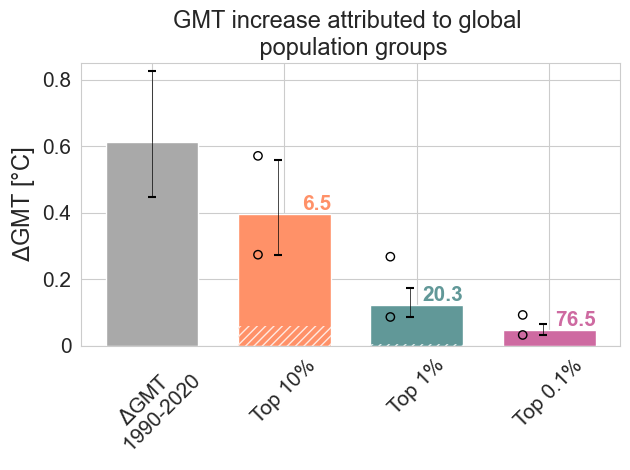

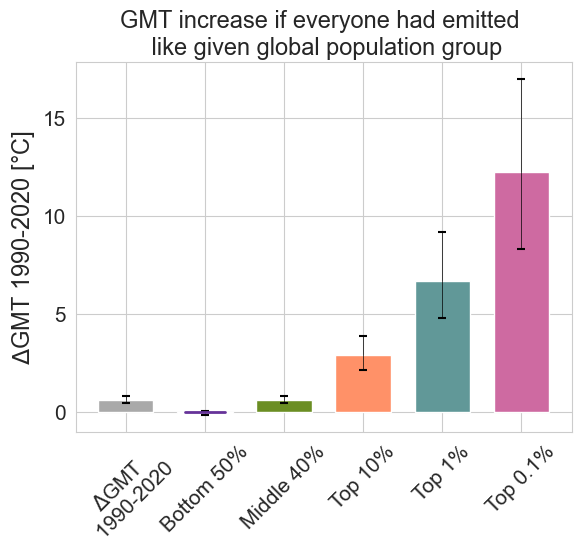

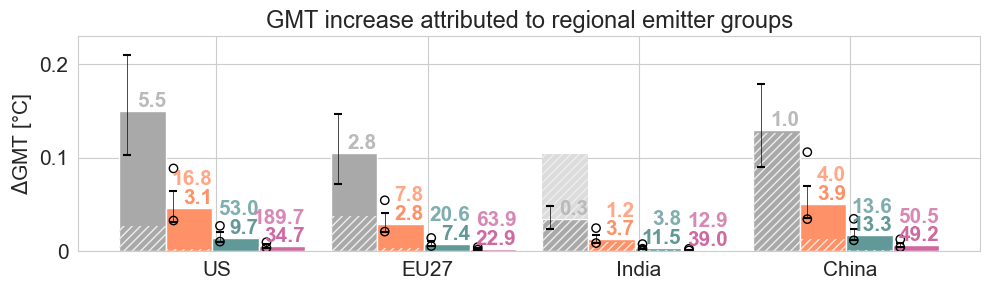

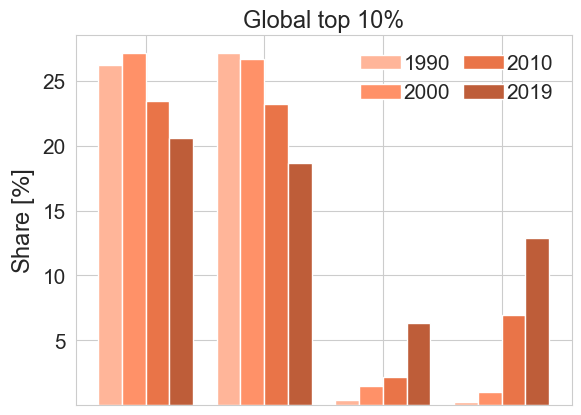

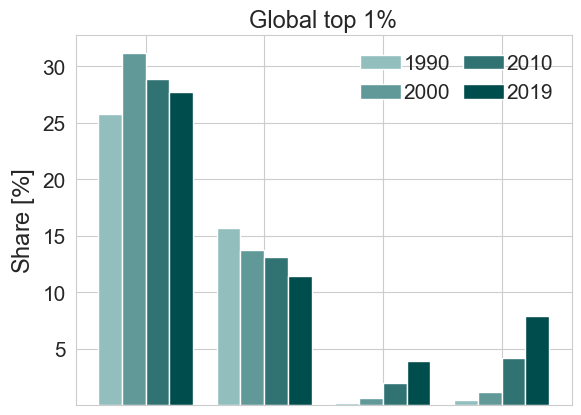

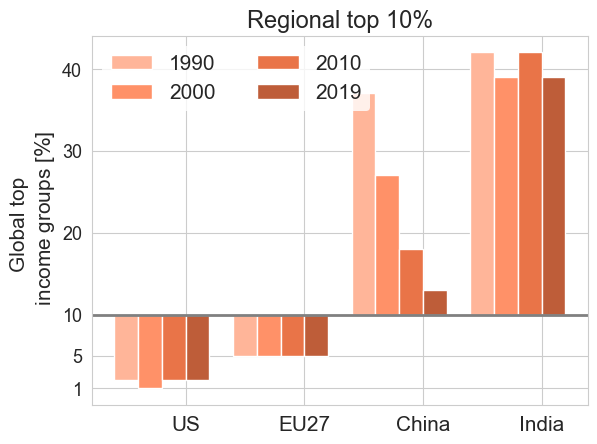

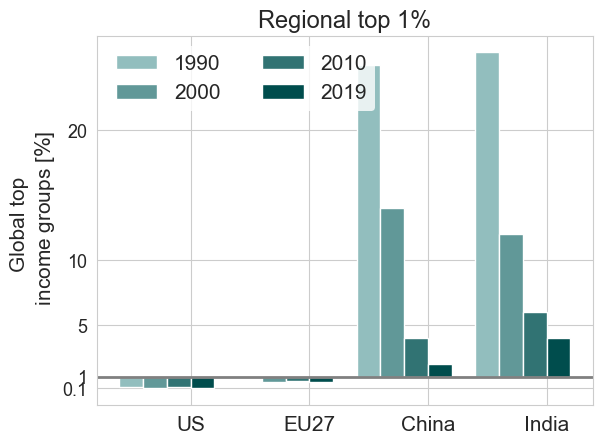

In [11]:
groups = ['p90p100', 'p99p100', 'p999p100']
group_sizes = [0.1, 0.01, 0.001]
labels = ['$\Delta$GMT \n 1990-2020', 'Top 10%', 'Top 1%', 'Top 0.1%']
with sns.axes_style('whitegrid'):
    fig, ax  = plt.subplots()
    attributed_gmt_plot(magicc_df, groups, group_sizes, labels, ax)
    fig.tight_layout()
    plt.show()

groups = ['p0p50', 'p50p90', 'p90p100', 'p99p100', 'p999p100']
labels = ['$\Delta$GMT \n 1990-2020', 'Bottom 50%', 'Middle 40%', 'Top 10%', 'Top 1%', 'Top 0.1%']
with sns.axes_style('whitegrid'):
    fig, ax  = plt.subplots()
    everyone_like_gmt_plot(magicc_df, groups, labels, ax)
    
with sns.axes_style('whitegrid'):
    fig, ax  = plt.subplots(figsize = (10,3))
    regional_gmt_plot(magicc_df, 
                    regions, 
                    ['p0p100', 'p90p100', 'p99p100', 'p999p100'], 
                    np.array([1,0.1,0.01,0.001]),
                    population_shares,
                    ax)
    fig.tight_layout()
    plt.show()

with sns.axes_style('whitegrid'):
    fig, ax  = plt.subplots()
    glogbal_top_distribution_plot('p90p100', 
                                  sns.color_palette("blend:#FFB599,#FF7F50,#BE5D39", as_cmap=True)(np.linspace(0,1,4)),
                                  [5,10,15,20,25],
                                  'Global top 10%',
                                  ax)
    plt.show()
    
with sns.axes_style('whitegrid'):
    fig, ax  = plt.subplots()
    glogbal_top_distribution_plot('p99p100', 
                                  sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.2,1,4)),
                                  [5,10,15,20,25,30],
                                  'Global top 1%',
                                  ax)
    plt.show()
    
with sns.axes_style('whitegrid'):
    fig, ax  = plt.subplots()
    mapping_regional_to_global_plot('p90p100',
                                    sns.color_palette("blend:#FFB599,#FF7F50,#BE5D39", as_cmap=True)(np.linspace(0,1,4)),
                                    10, 
                                    [-9, -5, 0, 10, 20, 30], 
                                    [1,5,10,20,30,40],
                                    'Regional top 10%', 
                                    0,
                                    ax)
    plt.show()

with sns.axes_style('whitegrid'):
    fig, ax  = plt.subplots()
    mapping_regional_to_global_plot('p99p100',
                                    sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.2,1,4)),
                                    1, 
                                    [-0.9, 0, 4, 9, 19], 
                                    [0.1, 1, 5, 10, 20],
                                    'Regional top 1%', 
                                    0,
                                    ax)
    plt.show()

## Generating final plot


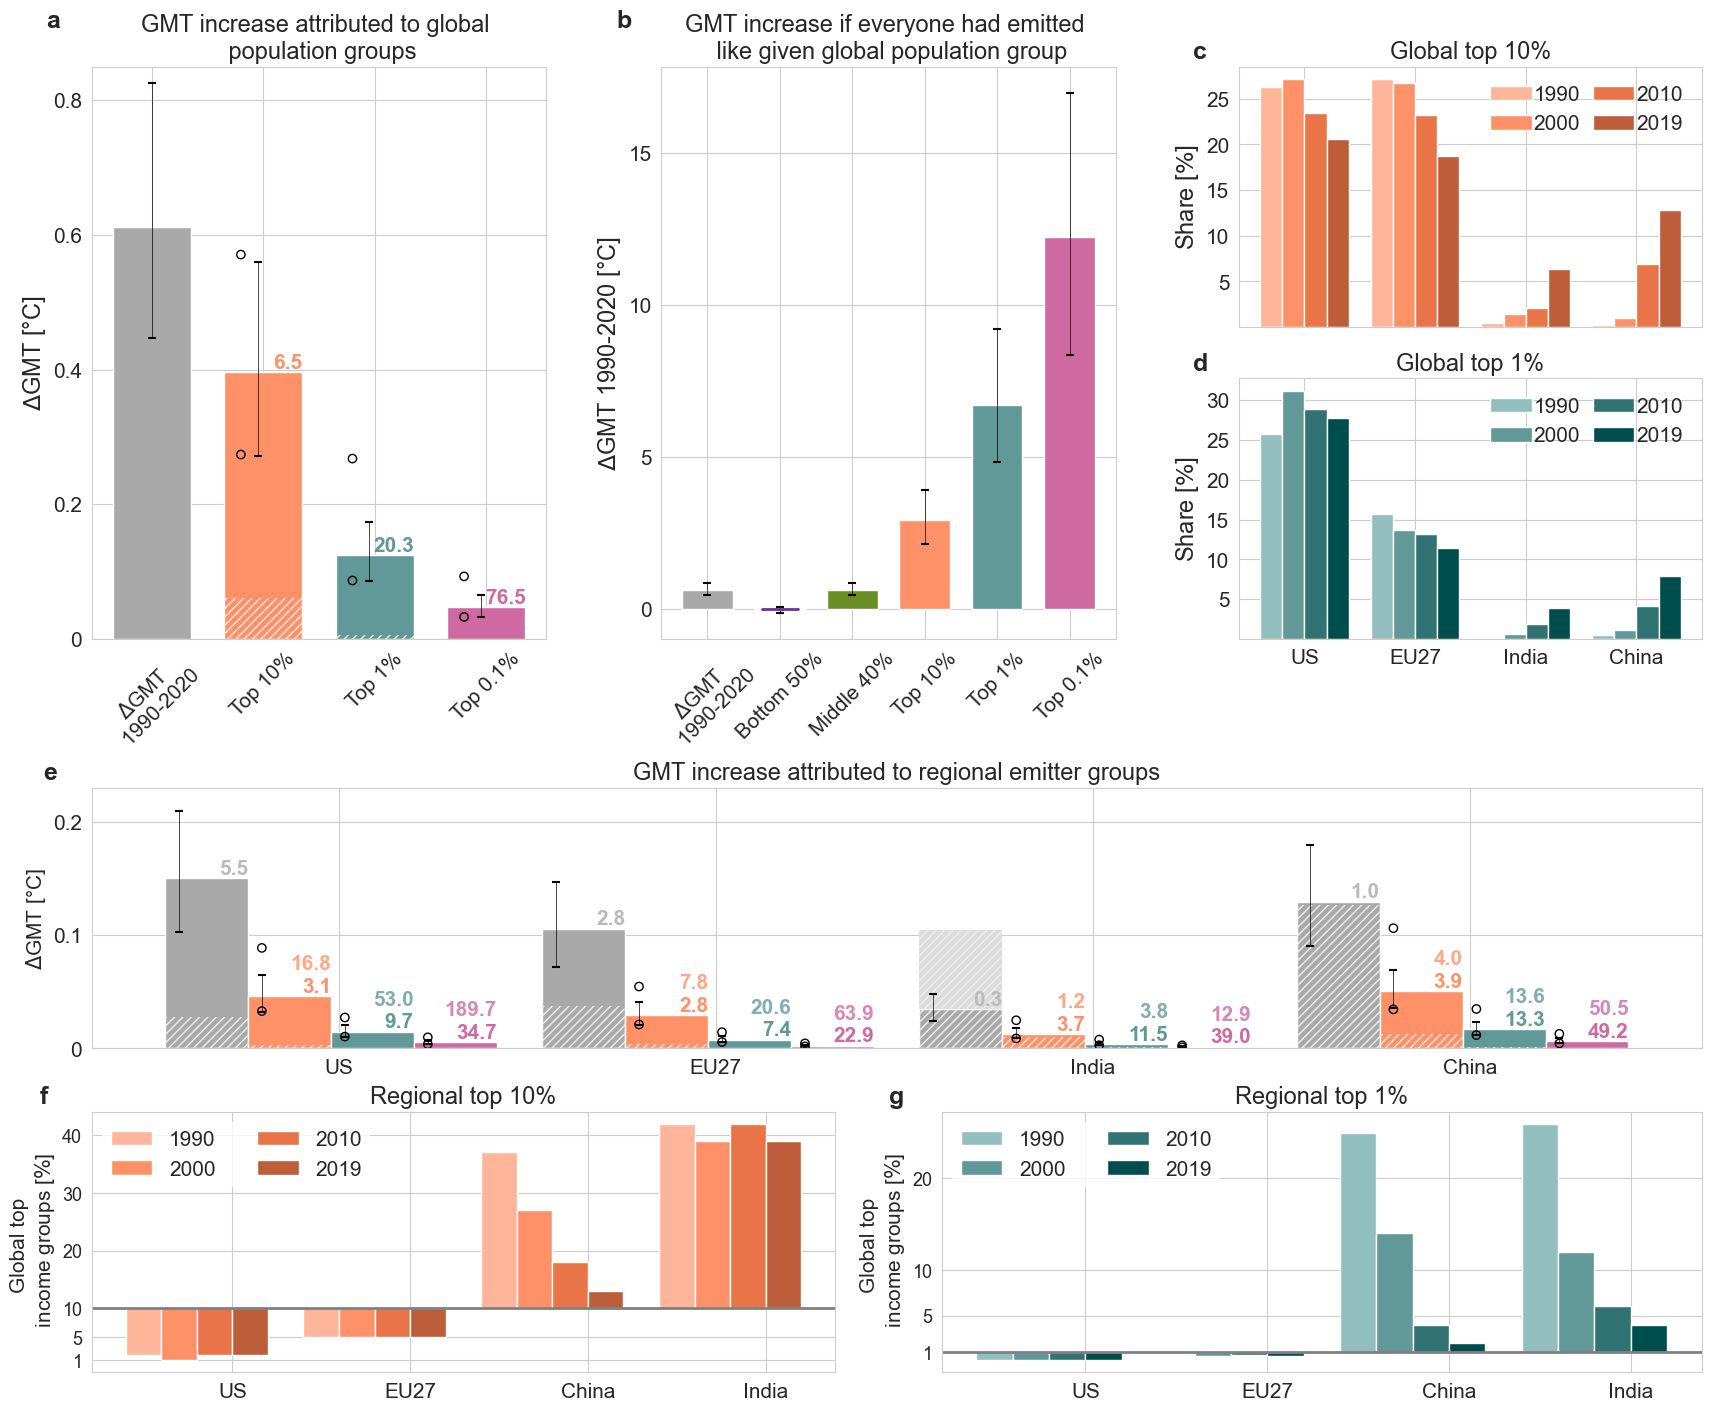

In [18]:
lettering = ['a', 'b','c', 'd', 'e', 'f', 'g'] 

with sns.axes_style('whitegrid'):
    fig = plt.figure(layout="constrained", figsize = (17,14))
    gs  = GridSpec(4, 6, figure=fig)
    axes = []
    
    ### first graphic
    ax = fig.add_subplot(gs[:2, :2])
    groups = ['p90p100', 'p99p100', 'p999p100']
    group_sizes = [0.1, 0.01, 0.001]
    labels = ['$\Delta$GMT \n 1990-2020', 'Top 10%', 'Top 1%', 'Top 0.1%']
    attributed_gmt_plot(magicc_df, groups, group_sizes, labels, ax)
    axes.append(ax)
    
    ### second graphic
    ax = fig.add_subplot(gs[:2, 2:4])
    groups = ['p0p50', 'p50p90', 'p90p100', 'p99p100', 'p999p100']
    labels = ['$\Delta$GMT \n 1990-2020', 'Bottom 50%', 'Middle 40%', 'Top 10%', 'Top 1%', 'Top 0.1%']
    everyone_like_gmt_plot(magicc_df, groups, labels, ax)
    axes.append(ax) 
    
    ### thrid graphic 
    ax = fig.add_subplot(gs[:1, 4:])
    glogbal_top_distribution_plot('p90p100', 
                                sns.color_palette("blend:#FFB599,#FF7F50,#BE5D39", as_cmap=True)(np.linspace(0,1,4)),
                                [5,10,15,20,25],
                                'Global top 10%',
                                ax)
    axes.append(ax)
    
    ### fourth graphic 
    ax = fig.add_subplot(gs[1:2, 4:])
    glogbal_top_distribution_plot('p99p100', 
                                sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.2,1,4)),
                                [5,10,15,20,25,30],
                                'Global top 1%',
                                ax, 
                                x_tick_labels = sel_region_names)    
    axes.append(ax)
    
    ### fifth graphic
    ax = fig.add_subplot(gs[2:3, :])
    regional_gmt_plot(magicc_df, 
                    regions, 
                    ['p0p100', 'p90p100', 'p99p100', 'p999p100'], 
                    np.array([1,0.1,0.01,0.001]),
                    population_shares,
                    ax)    
    axes.append(ax)
    
    ### sixth graphic 
    ax = fig.add_subplot(gs[3:4, :3])
    mapping_regional_to_global_plot('p90p100',
                                    sns.color_palette("blend:#FFB599,#FF7F50,#BE5D39", as_cmap=True)(np.linspace(0,1,4)),
                                    10, 
                                    [-9, -5, 0, 10, 20, 30], 
                                    [1,5,10,20,30,40],
                                    'Regional top 10%', 
                                    0,
                                    ax)
    axes.append(ax)
    
    ### seventh graphic
    ax = fig.add_subplot(gs[3:4, 3:])
    mapping_regional_to_global_plot('p99p100',
                                    sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.2,1,4)),
                                    1, 
                                    [0, 4, 9, 19], 
                                    [1, 5, 10, 20],
                                    'Regional top 1%', 
                                    0,
                                    ax)
    axes.append(ax)

    xs = [-0.1, -0.1, -0.1,-0.1,-0.03, -0.07, -0.07]
    ys = [1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]
    for i in range(7):
        axes[i].text(xs[i], ys[i], lettering[i], transform=axes[i].transAxes, fontsize=fontsize_large+1, fontweight='bold', va='top')
    Path(GRAPHICS_PAPER_MAIN_DIR).mkdir(parents=True, exist_ok=True)
    plt.savefig(GRAPHICS_PAPER_MAIN_DIR / '002_display_item.pdf', dpi = 600)
    # plt.savefig(path_output / '002_display_item.pgf', dpi = 600)
    plt.show()

## Generating Table with all important numbers

In [13]:
# group_deltas, group_delta_bounds, group_deltas_fair, delta_gmt, delta_gmt_bounds = data_for_attributed_gmt(magicc_df,
#                                                                                                            ['p90p100', 'p99p100', 'p999p100'],
#                                                                                                            np.array([0.1,0.01,0.001]))
# regional_group_deltas, regional_group_delta_bounds, regional_group_deltas_equal = data_for_regional_gmt(magicc_df, 
#                                                                                                         regions,
#                                                                                                         ['p0p100', 'p90p100', 'p99p100', 'p999p100'],
#                                                                                                         np.array([1,0.1,0.01,0.001]),
#                                                                                                         population_shares)
# gmt_result_df = pd.DataFrame(columns = ['region', 'group', 'scaling_assumption', 'mean', 'lower_bound', 'upper_bound', 'equal_share'])

# row = 0
# gmt_result_df.loc[row, :] = ['global', 'p0p100', 'historic', delta_gmt, delta_gmt_bounds[0], delta_gmt_bounds[1], np.nan]

# row += 1

# for i_group, group in enumerate(['p90p100', 'p99p100', 'p999p100']): 
#     for i_assumption, assumption in enumerate(scaling_assumptions): 
#         gmt_result_df.loc[row, :] = ['global', group, assumption, group_deltas[i_assumption, i_group], group_delta_bounds[i_assumption, i_group, 0], group_delta_bounds[i_assumption, i_group, 1], group_deltas_fair[i_group]]
#         row += 1

# for i_region, region in enumerate(regions):
#     for i_group, group in enumerate(['p0p100', 'p90p100', 'p99p100', 'p999p100']):
#         for i_assumption, assumption in enumerate(scaling_assumptions):
#             gmt_result_df.loc[row, :] = [region, group, assumption, regional_group_deltas[i_assumption, i_region, i_group], regional_group_delta_bounds[i_assumption, i_region, i_group, 0], regional_group_delta_bounds[i_assumption, i_region, i_group, 1], regional_group_deltas_equal[i_region, i_group]]
#             row += 1

# Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)
# gmt_result_df.to_csv(RESULTS_DIR / 'Attributed_GMT.csv')

In [14]:
group_deltas, group_delta_bounds, group_deltas_fair, delta_gmt, delta_gmt_bounds = data_for_attributed_gmt(magicc_df,
                                                                                                           ['p90p100', 'p99p100', 'p999p100'],
                                                                                                           np.array([0.1,0.01,0.001]))
regional_group_deltas, regional_group_delta_bounds, regional_group_deltas_equal = data_for_regional_gmt(magicc_df, 
                                                                                                        regions,
                                                                                                        ['p0p100', 'p90p100', 'p99p100', 'p999p100'],
                                                                                                        np.array([1,0.1,0.01,0.001]),
                                                                                                        population_shares)
gmt_result_df = pd.DataFrame(columns = ['region', 'group', 
                                        'CO2-scaling_mean', 'CO2-scaling_lower-bound', 'CO2-scaling_upper-bound', 
                                        'equal-scaling_mean', 'equal-scaling_lower-bound', 'equal-scaling_upper-bound', 
                                        'equal_share',
                                        'CH4-scaling_mean', 'CH4-scaling_lower-bound', 'CH4-scaling_upper-bound', ])

row = 0
gmt_result_df.loc[row, :] = ['global', 'historic', 
                             np.nan, np.nan, np.nan, 
                             delta_gmt, delta_gmt_bounds[0], delta_gmt_bounds[1], 
                             np.nan,
                             np.nan, np.nan, np.nan,
                            ]

row += 1

for i_group, group in enumerate(['top 10', 'top 1', 'top 0.1']): 
    gmt_result_df.loc[row, :] = ['global', group, 
                                group_deltas[0, i_group], group_delta_bounds[0, i_group, 0], group_delta_bounds[0, i_group, 1],
                                group_deltas[1, i_group], group_delta_bounds[1, i_group, 0], group_delta_bounds[1, i_group, 1],
                                group_deltas_fair[i_group],
                                group_deltas[2, i_group], group_delta_bounds[2, i_group, 0], group_delta_bounds[2, i_group, 1],
                                ]
    row += 1

for i_region, region in enumerate(regions):
    for i_group, group in enumerate(['all', 'top 10', 'top 1', 'top 0.1']):
        gmt_result_df.loc[row, :] = [region, group, 
                                        regional_group_deltas[0, i_region, i_group], regional_group_delta_bounds[0, i_region, i_group, 0], regional_group_delta_bounds[0, i_region, i_group, 1], 
                                        regional_group_deltas[1, i_region, i_group], regional_group_delta_bounds[1, i_region, i_group, 0], regional_group_delta_bounds[1, i_region, i_group, 1], 
                                        regional_group_deltas_equal[i_region, i_group],
                                        regional_group_deltas[2, i_region, i_group], regional_group_delta_bounds[2, i_region, i_group, 0], regional_group_delta_bounds[2, i_region, i_group, 1]
                                        ]
        row += 1

gmt_result_df.iloc[:, 2:] = gmt_result_df.iloc[:, 2:].astype(float).round(decimals = 3)

Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)
gmt_result_df.to_csv(RESULTS_DIR / 'Attributed_GMT.csv')

In [15]:
from tabulate import tabulate

Path(GRAPHICS_PAPER_APPENDIX_DIR / 'tables').mkdir(parents=True, exist_ok=True)

gmt_tmp = gmt_result_df.iloc[:, 1:].copy()
gmt_tmp.index = gmt_result_df.region

with open(GRAPHICS_PAPER_APPENDIX_DIR / 'tables' / 'Attributed_GMT.txt', 'w') as f:
    f.write(tabulate(gmt_tmp, tablefmt='latex'))